In [ ]:
!pip install transformers==3.1.0
!pip install langdetect

# Blog post: https://towardsdatascience.com/zero-shot-text-classification-with-hugging-face-7f533ba83cd6

     |████████████████████████████████| 890kB 8.3MB/s 
     |████████████████████████████████| 3.0MB 46.4MB/s 
     |████████████████████████████████| 1.2MB 42.5MB/s 
     |████████████████████████████████| 901kB 48.3MB/s 
     |████████████████████████████████| 983kB 6.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=849218fe9712ab997fe836dd2b873217cfff0d0dd2f7d3a8a25fd5c2bd299c31
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
import csv
import re
import time
import traceback
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup
from langdetect import detect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import argmax

from transformers import pipeline

In [ ]:
classifier = pipeline("zero-shot-classification", device=0) # to utilize GPU

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
debug_mode = True
visited_websites = []
MAX_ROWS = 100
cur_no_rows = 0
LANGUAGE = "en"

# defining the googleSearch function
def googleSearch(query):
    # making the url ready for requests
    url = 'https://www.google.com/search?num=100&client=ubuntu&q={}&ie=utf-8&oe=utf-8'.format(query);
    # generating a random user agent using the randomAgent function we previously defined
    user_agent = "Mozilla/5.0 (X11; Linux x86_64; rv:2.0b9pre) Gecko/20110111 Firefox/4.0b9pre"
    print("user agent", user_agent)
    # defining header for the request function
    ran_head = {
        'user-agent': user_agent
    }
	  # declaring list g_clean to store the fetched urls
    g_clean = []
    # exception handling code to make sure we don't run into errors
    try:
        # fetching the response using get method in requests
        html = requests.get(url)
        # checking the response status to be success
        if html.status_code == 200:
            # parsing the fetched html in the response using lxml parser in beautiful soup
            soup = BeautifulSoup(html.text, 'lxml')

            # finding all the 'a' tags, links, in the parsed html
            a = soup.find_all('a')
            # looping through the all found a tags for processing
            for i in a:
                # extracting the href attribute for the link to the search results
                k = i.get('href')
                # exception handling code to prevent running into erros
                try:
                    # search for the pattern of a url to prevent unnecessary attributes in the result using re module
                    m = re.search("(?P<url>https?://[^\s]+)", k)
                    # fetching only the url part in the array
                    n = m.group(0)
                    # splitting the url upto the parameters part to get only the necessary url
                    rul = n.split('&')[0]
                    # parsing the url to divide it into components using urlparse
                    domain = urlparse(rul)
                    # checking if the fetched url belongs to google.com if true skip the url
                    if (re.search('google.com', domain.netloc)):
                        continue
                    # else add it to the result list
                    else:
                        g_clean.append(rul)
                except:
                    continue
    except Exception as ex:

        print(traceback.format_exc())
    # finally return the result urls
    finally:
        return g_clean


# grabs the title the headers information from a certain URL
def scrapHTML(url, writer, level=0):
    if("twitter.com" in url):
        print("skipping", url)
        return
    if("youtube.com" in url):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'pdf'):
        print("skipping", url)
        return
    if("pdf" in url):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'jpg'):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'jpeg'):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'png'):
        print("skipping", url)
        return
    if ("download" in url):
        print("skipping", url)
        return
    if ("file" in url):
        print("skipping", url)
        return

    #making sure the website is not scrapped twice
    if url in visited_websites:
        return
    visited_websites.append(url)

    print(url, level)
    # exception handling code to make sure we don't run into errors
    try:
        # fetching the response using get method in requests
        if debug_mode:
            print("............start processing ", url)
        headers =  {
            "User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"
        }
        html = requests.get(url, headers=headers, timeout=10)
        # checking the response status to be success
        soup =  None
        if html.status_code == 200:
            # parsing the fetched html in the response using lxml parser in beautiful soup
            soup = BeautifulSoup(html.content, 'lxml')
            soup.encode("utf-8")
            soup.prettify('utf-8')
            span = soup.find_all('span', limit=300)
            # looping through the all found a tags for processing
            for i in span:
                try:
                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                       content = i.get_text(strip=False)
                       if (content.startswith("%PDF-")):
                           print("skipping PDF content", url)
                           return
                       write_content(content, writer, url, level)
                except Exception as exParse:
                    if debug_mode:
                       print("herror on span parsing", exParse)
                    continue

            if debug_mode:
                print("............Step 6 - span extraction : done!")

            p = soup.find_all('p', limit=300)
            # looping through the all found a tags for processing
            for i in p:
                try:
                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                        content = i.get_text(strip=False)
                        if(content.startswith("%PDF-")) :
                           print("skipping PDF content", url)
                           return
                        write_content(content, writer, url, level)
                except Exception as exParse:
                    if debug_mode:
                        print("herror on p parsing", exParse)
                    continue

            if debug_mode:
                print("............Step 7 - p extraction : done!")

            divs = soup.find_all('div', limit=300)
            # looping through the all found a tags for processing
            for i in divs:
                try:

                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                        content = i.get_text(strip=False)
                        if(content.startswith("%PDF-")) :
                            print("skipping PDF content", url)
                            return
                        write_content(content, writer, url, level)

                except Exception as exParse:
                    if debug_mode:
                        print("herror on div parsing", exParse, url, content)
                        print(traceback.format_exc())
                    continue
            if debug_mode:
                print("............Step 8 - div extraction : done!")

            # only go on second level if wikipedia
            if level == 0 and not ("wikipedia.org" in url):
                return

                # only visit wikipedia pages in the required language
            if level == 1 and not (("https://" + LANGUAGE) in url):
                return

            if level == 0:
                # finding all the 'a' tags, links, in the parsed html
                a = soup.find_all('a')
                # looping through the all found a tags for processing
                for i in a:
                    # extracting the href attribute for the link to the search results
                    k = i.get('href')
                    # exception handling code to prevent running into erros
                    try:
                        # search for the pattern of a url to prevent unnecessary attributes in the result using re module
                        m = re.search("(?P<url>https?://[^\s]+)", k)
                        # fetching only the url part in the array
                        n = m.group(0)
                        # splitting the url upto the parameters part to get only the necessary url
                        rul = n.split('&')[0]
                        # parsing the url to divide it into components using urlparse
                        domain = urlparse(rul)
                        # checking if the fetched url belongs to google.com if true skip the url
                        if (re.search('google.com', domain.netloc)):
                            continue
                        # else add it to the result list
                        else:
                            if not(check_same_domain(url, rul)) :
                                scrapHTML(rul, writer, 1)
                    except Exception as ex:
                        continue

    except Exception as ex:
       if debug_mode:
          print(ex)
          print(traceback.format_exc())

def get_csv_file_name(text_query):
    return '/content/google_results.csv'

def check_same_domain(url, other_url):
    #remove the protocol
    url = url.replace("https://", "")

    cut_here = url.find("/")
    if cut_here == -1:
        cut_here = url.find("?")

    if(cut_here > 0):
        url = url[0:cut_here]

    result = False
    if url in other_url:
        result = True

    return result


# writes the text into the csv file
def write_content(content, writer, url, level):
    # remove links from text
    content = re.sub(r'^https?:\/\/.*[\r\n]*', '', content, flags=re.MULTILINE)

    # if a longer phrase
    if len(content) > 150 and detect(content) == LANGUAGE:
        content = content.replace('\n', ' ').replace('\r', ' ')
        writer.writerow({'content': content.strip(), 'url': url, 'type': 'content', 'level': level})

In [ ]:
# Calling search function
text_query = 'climate fight history'

startTime = time.time()
googleResults = googleSearch(text_query)
with open(get_csv_file_name(text_query), 'w', newline='', encoding="utf-8") as file:
    fieldnames = ['content', 'url', 'type', 'level']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for resultURL in googleResults:
        url_content= scrapHTML(resultURL, writer)

duration = time.time() - startTime
print(duration)

user agent Mozilla/5.0 (X11; Linux x86_64; rv:2.0b9pre) Gecko/20110111 Firefox/4.0b9pre
https://en.wikipedia.org/wiki/Climate_movement 0
............start processing  https://en.wikipedia.org/wiki/Climate_movement
............Step 6 - span extraction : done!
............Step 7 - p extraction : done!
............Step 8 - div extraction : done!
http://news.bbc.co.uk/1/hi/world/europe/8410414.stm 1
............start processing  http://news.bbc.co.uk/1/hi/world/europe/8410414.stm
............Step 6 - span extraction : done!
............Step 7 - p extraction : done!
............Step 8 - div extraction : done!
https://web.archive.org/web/20091215101510/http://news.bbc.co.uk/1/hi/world/europe/8410414.stm 1
............start processing  https://web.archive.org/web/20091215101510/http://news.bbc.co.uk/1/hi/world/europe/8410414.stm
............Step 6 - span extraction : done!
............Step 7 - p extraction : done!
............Step 8 - div extraction : done!
http://edition.cnn.com/2009/WORLD/e

In [ ]:
#df = pd.read_csv('/content/google_results.csv', usecols=['content'], nrows=50)
df = pd.read_csv('/content/google_results.csv', usecols=['content'])
df.shape

(4219, 1)

In [ ]:
for sent in df['content'].values:
  print(sent)
  print()

Streaming output truncated to the last 5000 lines.
Despite dramatic differences in tactics, Carmichael, the SNCC, the Black Panthers, SDS, and Weatherman all understood one thing: the basis for political activism lies not in moral conviction or good intentions, but in socio-economic consciousness.  That is, real and effective politics stem from people acting in the recognition of their own structural self-interest.  For climate justice, such a re-articulation could open up a completely different set of tactical options.  Self-defense options.  As Belalia notes, “for many in this country, resistance isn’t a choice – it’s plain survival.”

Tactically, the New Abolitionists have espoused a return to civil disobedience as an expression of their radicalism, their willingness to confront “public enemy number one” – the fossil fuel industry—in person and on the ground.   Certainly, this re-embrace of a set of tactics which has wrongfully acquired such a bad rap since the 1970s is refreshing a

In [ ]:
candidate_labels = ["renewable", "politics", "emission", "temperature", "emergency", "advertisment"]
candidate_results = [0, 0, 0, 0, 0, 0]

for sent in df['content'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels)

    SCORES = res["scores"]
    CLASSES = res["labels"]
    BEST_INDEX = argmax(SCORES)
    predicted_class = CLASSES[BEST_INDEX]
    predicted_score = SCORES[BEST_INDEX]

    if predicted_class == 'renewable' and predicted_score > 0.5:
        candidate_results[0] = candidate_results[0] + 1
    if predicted_class == 'politics' and predicted_score > 0.5:
        candidate_results[1] = candidate_results[1] + 1
    if predicted_class == 'emission' and predicted_score > 0.5:
        candidate_results[2] = candidate_results[2] + 1
    if predicted_class == 'temperature' and predicted_score > 0.5:
        candidate_results[3] = candidate_results[3] + 1
    if predicted_class == 'emergency' and predicted_score > 0.5:
        candidate_results[4] = candidate_results[4] + 1
    if predicted_class == 'advertisment' and predicted_score > 0.5:
        candidate_results[5] = candidate_results[5] + 1

    if res['scores'][0] > 0.5:
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print()

print(candidate_results)

Streaming output truncated to the last 5000 lines.
['emission', 'emergency', 'advertisment', 'temperature', 'renewable', 'politics']
[0.8358811140060425, 0.08852376788854599, 0.03110845573246479, 0.02132510021328926, 0.01219941582530737, 0.010962139815092087]

The protesting students have vowed to continue boycotting classes on Fridays until their countries adhere to the 2015 Paris climate agreement, which aims to prevent global temperatures from rising 1.5C (2.7F) above pre-industrial levels.
['temperature', 'politics', 'emission', 'emergency', 'advertisment', 'renewable']
[0.5442599058151245, 0.2209850698709488, 0.08907235413789749, 0.08062543720006943, 0.03766033425927162, 0.02739696390926838]

In an open letter published in Germany's Süddeutsche Zeitung on the eve of Friday's strike, Ms Thunberg and prominent German climate activist Luisa Neubauer, 22, called on older generations to join the action in September.
['politics', 'renewable', 'emergency', 'temperature', 'emission', 'adv

In [ ]:
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)

,labels,values
0,renewable,87
1,politics,371
2,emission,525
3,temperature,211
4,emergency,147
5,advertisment,40


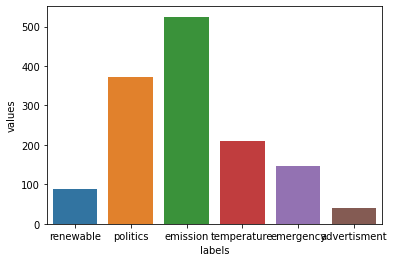

In [ ]:
sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )

In [ ]:
candidate_labels = ["renewable", "politics", "emission", "temperature", "emergency", "advertisment"]
candidate_results = [0, 0, 0, 0, 0, 0]

for sent in df['content'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels, multi_class=True)

    print_flag = 0
    for index, score in enumerate(res['scores']):
      if score > 0.5:
        if res['labels'][index] == 'renewable':
          candidate_results[0] = candidate_results[0] + 1
        if res['labels'][index] == 'politics':
          candidate_results[1] = candidate_results[1] + 1
        if res['labels'][index] == 'emission':
          candidate_results[2] = candidate_results[2] + 1
        if res['labels'][index] == 'temperature':
          candidate_results[3] = candidate_results[3] + 1
        if res['labels'][index] == 'emergency':
          candidate_results[4] = candidate_results[4] + 1
        if res['labels'][index] == 'advertisment':
          candidate_results[5] = candidate_results[5] + 1
        
        if print_flag == 0:
          print(sent)
          print(res['labels'])
          print(res['scores'])
          print()
          print_flag = 1

print(candidate_results)

The Earth's atmosphere is warming, faster than it probably ever has. In some cases weather patterns, climates and natural environments are changing quicker than wildlife or people can adapt.
['temperature', 'emergency', 'emission', 'advertisment', 'renewable', 'politics']
[0.9710330367088318, 0.5734952092170715, 0.2849346995353699, 0.03822522982954979, 0.017728641629219055, 0.004734331741929054]

Global temperatures have been rising for over a century, speeding up in the last few years, and are now the highest on record. This causes negative impacts such as the melting of Arctic sea-ice, prolonged heat-waves and rising sea-levels.
['temperature', 'emergency', 'emission', 'advertisment', 'politics', 'renewable']
[0.9947116374969482, 0.41137099266052246, 0.21819810569286346, 0.06036447733640671, 0.003252425929531455, 0.002015947364270687]

We know why. We release carbon dioxide into the atmosphere by burning fossil fuels for energy, farming, and destroying forests. These carbon emissions

In [ ]:
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)

,labels,values
0,renewable,138
1,politics,375
2,emission,584
3,temperature,167
4,emergency,196
5,advertisment,77


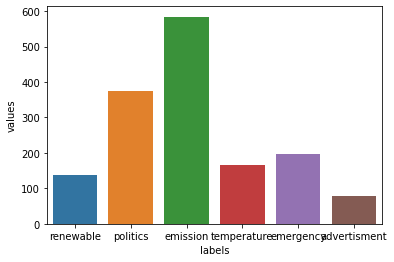

In [ ]:
sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )